In [1]:
import pandas as pd
import numpy as np

# Load data
csv_file_path = '/Users/balmeru/Downloads/1987.csv' 
df = pd.read_csv(csv_file_path)

columns_to_check = ['ajexdi', 'prccd', 'trfd']
df.dropna(subset=columns_to_check, how='any', inplace=True)

date_format = '%Y-%m-%d'  
df['datadate'] = pd.to_datetime(df['datadate'], format=date_format)
df.sort_values(by=['tic', 'datadate'], inplace=True)

df['adjusted_close'] = df['prccd'] / df['ajexdi']
df['adjusted_close_prior'] = df.groupby('tic')['adjusted_close'].shift(1)
df['trfd_prior'] = df.groupby('tic')['trfd'].shift(1)

df['daily_return'] = (
    ((df['adjusted_close'] * df['trfd']) /
     (df['adjusted_close_prior'] * df['trfd_prior'])) - 1
) * 100

df['day_diff'] = df.groupby('tic')['datadate'].diff().dt.days 
df.loc[df['day_diff'] > 5, 'daily_return'] = np.nan

pivot_df = df.pivot_table(index='datadate', columns='tic', values='daily_return')

pivot_df1 = pivot_df.map(lambda x: x / 100 if pd.notnull(x) else np.nan)

adjusted_daily_returns = pivot_df1.map(lambda x: x + 1 if pd.notnull(x) else np.nan)

def consecutive_zeros(prices):
    count = 0
    max_count = 0
    for price in prices:
        if price == 0:
            count += 1
            max_count = max(max_count, count) 
        else:
            count = 0
    return max_count

consecutive_zero_counts = df.groupby('tic')['prccd'].apply(consecutive_zeros)

for ticker, max_zeros in consecutive_zero_counts.items():
    if max_zeros > 5:
        warnings.warn(f"Warning: Ticker '{ticker}' has more than 5 consecutive zeros in 'prccd'.")

all_weekdays = pd.date_range(start=adjusted_daily_returns.index.min(), end=adjusted_daily_returns.index.max(), freq='B')  
df_reindexed = adjusted_daily_returns.reindex(all_weekdays)

all_mondays = pd.date_range(start=df_reindexed.index.min(), end=df_reindexed.index.max(), freq='W-MON')
weekly_pivot_df = pd.DataFrame(data=np.nan, index=all_mondays, columns=df_reindexed.columns)
ticker_start_dates = df_reindexed.apply(lambda x: x.first_valid_index(), axis=0)

for i, monday in enumerate(all_mondays):
    start_date = monday
    if i < len(all_mondays) - 1:
        end_date = all_mondays[i + 1] - pd.DateOffset(days=1)
    else:
        end_date = df_reindexed.index.max()  # Last Monday
    
    weekly_data = df_reindexed.loc[start_date:end_date]
    for ticker in df_reindexed.columns:
        if monday < ticker_start_dates[ticker]:
            weekly_pivot_df.loc[monday, ticker] = np.nan
        else:
            if weekly_data.isnull().sum(axis=0)[ticker] == 5:
                weekly_pivot_df.loc[monday, ticker] = np.nan
            else:
                weekly_pivot_df.loc[monday, ticker] = (weekly_data[ticker].prod(skipna=True) - 1) * 100

pd.set_option('display.float_format', lambda x: f'{x:.2f}')  

weekly_pivot_path = "weekly_1987.csv"  
weekly_pivot_df.to_csv(weekly_pivot_path)
print(f"Weekly Pivot Table saved to: {weekly_pivot_path}")
print("Weekly Returns Pivot Table (first 10 rows):")
print(weekly_pivot_df.head(10))


Weekly Pivot Table saved to: weekly_1987.csv
Weekly Returns Pivot Table (first 10 rows):
tic         0223B  0485B  0491B  2185B  3213B  3219B  3234B  3557B  3614B  \
1986-12-08   0.56  -0.00  -2.56   4.00    NaN   0.00  -2.44    NaN  -1.38   
1986-12-15  -0.00   1.33   3.95 -15.38    NaN  -1.89   3.03    NaN   1.40   
1986-12-22  -2.21   0.00  -1.90  -2.27    NaN  -0.96  -2.94   3.09  -2.06   
1986-12-29   1.13   1.32  -0.65  11.63    NaN   0.97   0.00  -0.88   1.17   
1987-01-05   2.23  18.18   1.95   0.00    NaN   3.85   9.09  -0.89   4.17   
1987-01-12   0.00  -8.79   7.64   8.33    NaN   7.41  11.11   1.26   0.00   
1987-01-19   0.55   3.61   2.37   7.69    NaN  -6.90 -12.50   0.00   5.33   
1987-01-26   1.09   8.14  -7.51   0.00    NaN  -3.70   2.86  -0.89  -2.75   
1987-02-02  -0.54   5.38   5.00   0.00    NaN   1.92   5.56  -1.80  -0.88   
1987-02-09  -1.62  -1.02   7.74   1.79    NaN   3.77   2.63  -3.67  -2.43   

tic         3899B  ...  ZIGO  ZIM.1  ZING.1  ZION   ZMX   ZNT  

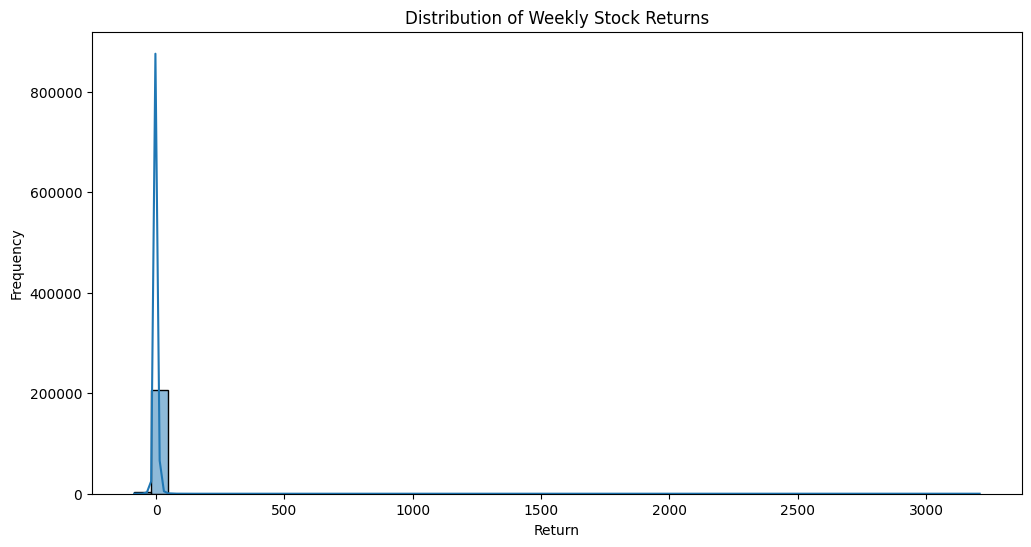

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
stacked_returns = weekly_pivot_df.stack()

plt.figure(figsize=(12, 6))
sns.histplot(stacked_returns, bins=50, kde=True)
plt.title('Distribution of Weekly Stock Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()



In [3]:
stacked_returns.describe()

count   210273.00
mean        -0.03
std         11.31
min        -85.71
25%         -2.99
50%          0.00
75%          2.61
max       3209.09
dtype: float64

In [4]:
df[columns_to_check].describe()


,ajexdi,prccd,trfd
count,1031573.00,1031573.00,1031573.00
mean,3.23,20.98,1.11
std,9.23,21.97,0.61
min,0.00,0.03,1.00
25%,1.00,7.88,1.00
50%,1.10,15.75,1.04
75%,3.00,27.38,1.12
max,324.00,565.00,46.95


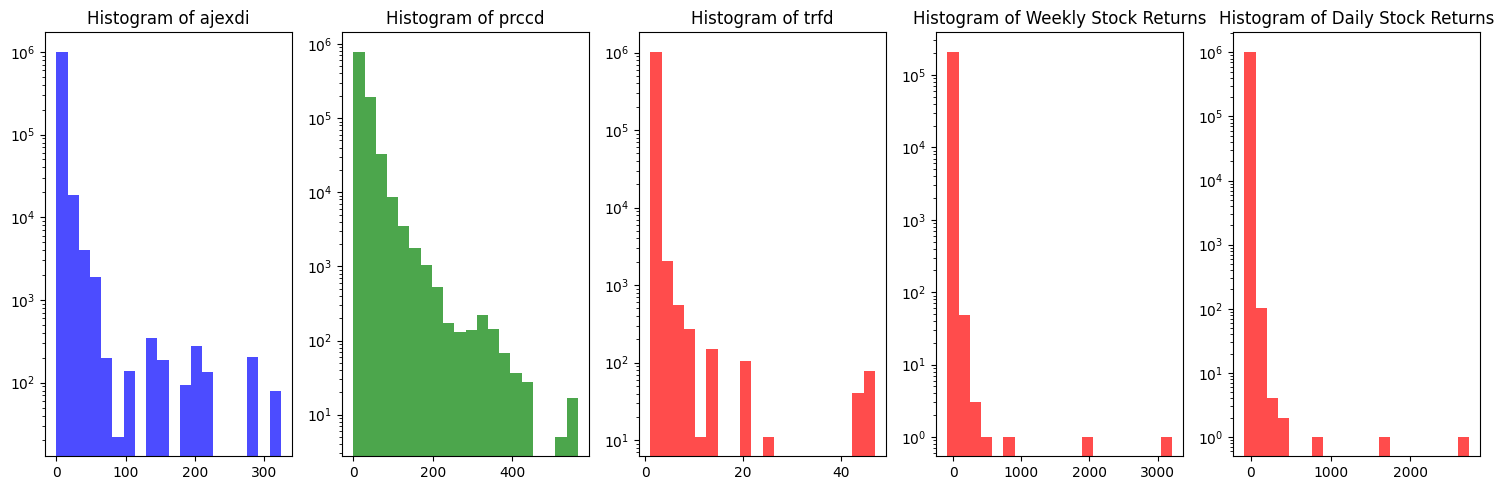

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pivot_ajexdi = df.pivot_table(index='datadate', columns='tic', values='ajexdi')
pivot_prccd = df.pivot_table(index='datadate', columns='tic', values='prccd')
pivot_trfd = df.pivot_table(index='datadate', columns='tic', values='trfd')

stacked_ajexdi = pivot_ajexdi.stack().reset_index(name='ajexdi')
stacked_prccd = pivot_prccd.stack().reset_index(name='prccd')
stacked_trfd = pivot_trfd.stack().reset_index(name='trfd')
plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
plt.hist(stacked_ajexdi['ajexdi'].dropna(), bins=20, color='blue', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of ajexdi')

plt.subplot(1, 5, 2)
plt.hist(stacked_prccd['prccd'].dropna(), bins=20, color='green', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of prccd')

plt.subplot(1, 5, 3)
plt.hist(stacked_trfd['trfd'].dropna(), bins=20, color='red', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of trfd')

plt.subplot(1, 5, 4)
plt.hist(stacked_returns.dropna(), bins=20, color='red', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of Weekly Stock Returns')


stacked_daily_returns = pivot_df.stack()
plt.subplot(1, 5, 5)
plt.hist(stacked_daily_returns.dropna(), bins=20, color='red', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of Daily Stock Returns')

plt.tight_layout()
plt.show()


In [6]:
stacked_daily_returns.describe()

count   1027421.00
mean          0.01
std           5.12
min         -83.95
25%          -1.27
50%           0.00
75%           1.16
max        2736.36
dtype: float64

In [7]:
# Calculate mean and standard deviation of daily returns
mean_daily_return = pivot_df.mean()
std_daily_return = pivot_df.std()

# Define upper and lower bounds for outliers based on mean ± 3 standard deviations
upper_bound = mean_daily_return + 3 * std_daily_return
lower_bound = mean_daily_return - 3 * std_daily_return

# Identify outliers using mean ± 3 standard deviations approach
outliers_mean_3sd = (pivot_df > upper_bound) | (pivot_df < lower_bound)

# Count number of outliers and total data points
num_outliers_mean_3sd = outliers_mean_3sd.sum().sum()
total_data_points = pivot_df.notnull().sum().sum()

# Print results
print(f"Number of outliers using mean ± 3 standard deviations approach: {num_outliers_mean_3sd}")
print(f"Total number of data points: {total_data_points}")

# Now you can repeat the process for MAD approach


Number of outliers using mean ± 3 standard deviations approach: 17459
Total number of data points: 1027421


In [8]:
import numpy as np

# Calculate median of each column
median_daily_return = pivot_df.median()

# Calculate absolute deviations from the median
abs_deviations = np.abs(pivot_df - median_daily_return)

# Calculate median absolute deviation (MAD) across all tickers
mad_daily_return = abs_deviations.median()

# Define upper and lower bounds for outliers based on median ± 3 MAD
upper_bound_mad = median_daily_return + 3 * mad_daily_return
lower_bound_mad = median_daily_return - 3 * mad_daily_return

# Identify outliers using median ± 3 MAD approach
outliers_mad = (pivot_df > upper_bound_mad) | (pivot_df < lower_bound_mad)

# Count number of outliers using MAD approach
num_outliers_mad = outliers_mad.sum().sum()

# Print results
print(f"Number of outliers using median ± 3 MAD approach: {num_outliers_mad}")


Number of outliers using median ± 3 MAD approach: 131993


In [9]:
#10893 is 1.57% of 692340, number of identified outliers with +-3st dev from mean 

In [10]:
mean = pivot_df.mean()
std = pivot_df.std()

num_std = 3
lower_bound = mean - num_std * std
upper_bound = mean + num_std * std

outliers_removed_df = pivot_df[(pivot_df >= lower_bound) & (pivot_df <= upper_bound)]
outliers_removed_df.stack().describe()



count   1009960.00
mean         -0.01
std           3.12
min         -83.33
25%          -1.23
50%           0.00
75%           1.12
max          75.07
dtype: float64

Text(0.5, 1.0, 'Histogram of Daily Stock Returns')

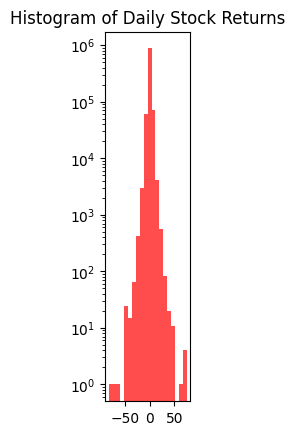

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
stacked_daily_returns_outliers_removed = outliers_removed_df.stack()
plt.subplot(1, 5, 5)
plt.hist(stacked_daily_returns_outliers_removed.dropna(), bins=20, color='red', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of Daily Stock Returns')

In [12]:


outliers_removed_df = outliers_removed_df.map(lambda x: x / 100 if pd.notnull(x) else np.nan)

adjusted_daily_returns = outliers_removed_df.map(lambda x: x + 1 if pd.notnull(x) else np.nan)

def consecutive_zeros(prices):
    count = 0
    max_count = 0
    for price in prices:
        if price == 0:
            count += 1
            max_count = max(max_count, count) 
        else:
            count = 0
    return max_count

consecutive_zero_counts = df.groupby('tic')['prccd'].apply(consecutive_zeros)

for ticker, max_zeros in consecutive_zero_counts.items():
    if max_zeros > 5:
        warnings.warn(f"Warning: Ticker '{ticker}' has more than 5 consecutive zeros in 'prccd'.")

all_weekdays = pd.date_range(start=adjusted_daily_returns.index.min(), end=adjusted_daily_returns.index.max(), freq='B')  
df_reindexed = adjusted_daily_returns.reindex(all_weekdays)

all_mondays = pd.date_range(start=df_reindexed.index.min(), end=df_reindexed.index.max(), freq='W-MON')
weekly_pivot_df = pd.DataFrame(data=np.nan, index=all_mondays, columns=df_reindexed.columns)
ticker_start_dates = df_reindexed.apply(lambda x: x.first_valid_index(), axis=0)

for i, monday in enumerate(all_mondays):
    start_date = monday
    if i < len(all_mondays) - 1:
        end_date = all_mondays[i + 1] - pd.DateOffset(days=1)
    else:
        end_date = df_reindexed.index.max()  # Last Monday
    
    weekly_data = df_reindexed.loc[start_date:end_date]
    for ticker in df_reindexed.columns:
        if monday < ticker_start_dates[ticker]:
            weekly_pivot_df.loc[monday, ticker] = np.nan
        else:
            if weekly_data.isnull().sum(axis=0)[ticker] == 5:
                weekly_pivot_df.loc[monday, ticker] = np.nan
            else:
                weekly_pivot_df.loc[monday, ticker] = (weekly_data[ticker].prod(skipna=True) - 1) * 100

pd.set_option('display.float_format', lambda x: f'{x:.2f}')  

weekly_pivot_path = "weekly_1987.csv"  
weekly_pivot_df.to_csv(weekly_pivot_path)
print(f"Weekly Pivot Table saved to: {weekly_pivot_path}")
print("Weekly Returns Pivot Table (first 10 rows):")
print(weekly_pivot_df.head(10))


Weekly Pivot Table saved to: weekly_1987.csv
Weekly Returns Pivot Table (first 10 rows):
tic         0223B  0485B  0491B  2185B  3213B  3219B  3234B  3557B  3614B  \
1986-12-08   0.56  -0.00  -2.56   4.00    NaN   0.00  -2.44    NaN  -1.38   
1986-12-15  -0.00   1.33   3.95 -15.38    NaN  -1.89   3.03    NaN   1.40   
1986-12-22  -2.21   0.00  -1.90  -2.27    NaN  -0.96  -2.94   3.09  -2.06   
1986-12-29   1.13   1.32  -0.65  11.63    NaN   0.97   0.00  -0.88   1.17   
1987-01-05   2.23  18.18   1.95   0.00    NaN   3.85   9.09  -0.89   4.17   
1987-01-12   0.00  -8.79  -2.14   8.33    NaN   7.41  11.11   1.26   0.00   
1987-01-19   0.55   3.61   2.37   7.69    NaN  -6.90 -12.50   0.00   5.33   
1987-01-26   1.09   8.14  -7.51   0.00    NaN  -3.70   2.86  -0.89  -2.75   
1987-02-02  -0.54   5.38   5.00   0.00    NaN   1.92   5.56  -1.80  -0.88   
1987-02-09  -1.62  -1.02   7.74   1.79    NaN   3.77   2.63  -3.67  -2.43   

tic         3899B  ...  ZIGO  ZIM.1  ZING.1  ZION   ZMX   ZNT  

In [13]:
weekly_pivot_df.stack().describe()

count   210264.00
mean        -0.10
std          6.12
min        -85.71
25%         -2.88
50%          0.00
75%          2.46
max        114.16
dtype: float64

In [16]:
#filtering daily return outliers with +-3st dev from mean only reduced weekly returns from
#count 210273.00 to 210264.00 by 9 data points only